In [1]:
import numpy as np

In [2]:
train_file = 'data/jetConstTrain_overlap.npz'
val_file = 'data/jetConstVal_overlap.npz'
test_file = 'data/jetConstTest_overlap.npz'

In [3]:
train_dataset = np.load(train_file)
val_dataset = np.load(val_file)
test_dataset = np.load(test_file)

In [4]:
test_dataset.X = {key:test_dataset[key] for key in test_dataset.keys()}

In [5]:
train_dataset.X = {key:train_dataset[key] for key in train_dataset.keys()}
val_dataset.X = {key:val_dataset[key] for key in val_dataset.keys()}
test_dataset.X = {key:test_dataset[key] for key in test_dataset.keys()}

In [6]:
train_dataset.y = train_dataset['labels']
train_dataset.X.pop('labels')

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [7]:
val_dataset.y = val_dataset['labels']
val_dataset.X.pop('labels')

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [8]:
test_dataset.y = test_dataset['labels']
test_dataset.X.pop('labels')

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [9]:
points = [ 'thetalab', 'radiilab']
features = ['pt', 'mass', 'eta', 'phi','zlab']
mask = ['pt']

In [10]:
points_array = np.stack([train_dataset[k].squeeze() for k in points], axis=-1)
features_array = np.stack([train_dataset[k].squeeze() for k in features], axis=-1)
mask_array = np.stack([train_dataset[k].squeeze() for k in mask], axis=-1)

points_array_v = np.stack([val_dataset[k].squeeze() for k in points], axis=-1)
features_array_v = np.stack([val_dataset[k].squeeze() for k in features], axis=-1)
mask_array_v = np.stack([val_dataset[k].squeeze() for k in mask], axis=-1)

points_array_t = np.stack([test_dataset[k].squeeze() for k in points], axis=-1)
features_array_t = np.stack([test_dataset[k].squeeze() for k in features], axis=-1)
mask_array_t = np.stack([test_dataset[k].squeeze() for k in mask], axis=-1)

In [11]:
print(points_array.shape)
print(features_array.shape)
print(mask_array.shape)
print()
print(points_array_v.shape)
print(features_array_v.shape)
print(mask_array_v.shape)
print()
print(points_array_t.shape)
print(features_array_t.shape)
print(mask_array_t.shape)

(8000, 10, 2)
(8000, 10, 5)
(8000, 10, 1)

(8000, 10, 2)
(8000, 10, 5)
(8000, 10, 1)

(4000, 10, 2)
(4000, 10, 5)
(4000, 10, 1)


In [12]:
train_dataset = {'points':points_array,
                 'features':features_array,
                 'mask':mask_array,
                 'labels':train_dataset['labels']
                }

val_dataset = {'points':points_array_v,
               'features':features_array_v,
               'mask':mask_array_v,
               'labels':val_dataset['labels']
                }


test_dataset = {'points':points_array_t,
               'features':features_array_t,
               'mask':mask_array_t,
               'labels':test_dataset['labels']
                }

```
            feature_dict['points'] = ['part_etarel', 'part_phirel']
            feature_dict['features'] = ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel']
            feature_dict['mask'] = ['part_pt_log']
```

In [13]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite

In [14]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [15]:
model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
num_classes = train_dataset['labels'].shape[1]
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset if not 'labels' in k}
if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)

In [16]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 2

In [17]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2021-03-15 14:41:25,129] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 10, 1)]      0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 10, 1)]      0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 10, 1)]      0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

In [19]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints/'
model_name = 'model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint =keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)   

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

[2021-03-15 14:41:25,229] WARNING: `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [20]:
X = {k:train_dataset[k]for k in train_dataset if not 'label' in k}
Y = train_dataset['labels']

Xval = {k:val_dataset[k]for k in val_dataset if not 'label' in k}
Yval = val_dataset['labels']

Xtest = {k:test_dataset[k]for k in test_dataset if not 'label' in k}
Ytest = test_dataset['labels']

In [21]:
# train_dataset.shuffle()
model.fit(X, Y,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=20, # --- train only for 1 epoch here for demonstration ---
          validation_data=(Xval, Yval),
          shuffle=True,
          callbacks=callbacks)

[2021-03-15 14:41:25,414] INFO: Learning rate: 0.001000


Train on 8000 samples, validate on 8000 samples
Epoch 1/20
Epoch 1/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.4722 - accuracy: 0.8414
Epoch 00001: val_loss improved from inf to 0.77983, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 4s 472us/sample - loss: 0.4412 - accuracy: 0.8569 - val_loss: 0.7798 - val_accuracy: 0.5000


[2021-03-15 14:41:29,195] INFO: Learning rate: 0.001000


Epoch 2/20
Epoch 2/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0853 - accuracy: 0.9937
Epoch 00002: val_loss did not improve from 0.77983
8000/8000 [==============================] - 1s 182us/sample - loss: 0.0811 - accuracy: 0.9936 - val_loss: 0.9160 - val_accuracy: 0.5000


[2021-03-15 14:41:30,657] INFO: Learning rate: 0.001000


Epoch 3/20
Epoch 3/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0289 - accuracy: 0.9940
Epoch 00003: val_loss did not improve from 0.77983
8000/8000 [==============================] - 1s 180us/sample - loss: 0.0279 - accuracy: 0.9942 - val_loss: 0.9986 - val_accuracy: 0.5000


[2021-03-15 14:41:32,100] INFO: Learning rate: 0.001000


Epoch 4/20
Epoch 4/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0143 - accuracy: 0.9965
Epoch 00004: val_loss did not improve from 0.77983
8000/8000 [==============================] - 1s 175us/sample - loss: 0.0142 - accuracy: 0.9964 - val_loss: 1.0340 - val_accuracy: 0.5000


[2021-03-15 14:41:33,505] INFO: Learning rate: 0.001000


Epoch 5/20
Epoch 5/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0088 - accuracy: 0.9979
Epoch 00005: val_loss did not improve from 0.77983
8000/8000 [==============================] - 1s 180us/sample - loss: 0.0085 - accuracy: 0.9979 - val_loss: 1.0275 - val_accuracy: 0.5000


[2021-03-15 14:41:34,947] INFO: Learning rate: 0.001000


Epoch 6/20
Epoch 6/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0056 - accuracy: 0.9990
Epoch 00006: val_loss did not improve from 0.77983
8000/8000 [==============================] - 1s 177us/sample - loss: 0.0055 - accuracy: 0.9990 - val_loss: 0.9654 - val_accuracy: 0.5000


[2021-03-15 14:41:36,370] INFO: Learning rate: 0.001000


Epoch 7/20
Epoch 7/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9994
Epoch 00007: val_loss did not improve from 0.77983
8000/8000 [==============================] - 1s 183us/sample - loss: 0.0039 - accuracy: 0.9994 - val_loss: 0.8673 - val_accuracy: 0.5000


[2021-03-15 14:41:37,839] INFO: Learning rate: 0.001000


Epoch 8/20
Epoch 8/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0035 - accuracy: 0.9992
Epoch 00008: val_loss improved from 0.77983 to 0.75010, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 197us/sample - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.7501 - val_accuracy: 0.5025


[2021-03-15 14:41:39,415] INFO: Learning rate: 0.001000


Epoch 9/20
Epoch 9/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0026 - accuracy: 0.9996
Epoch 00009: val_loss improved from 0.75010 to 0.62403, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 207us/sample - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.6240 - val_accuracy: 0.5279


[2021-03-15 14:41:41,078] INFO: Learning rate: 0.001000


Epoch 10/20
Epoch 10/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0022 - accuracy: 0.9999
Epoch 00010: val_loss improved from 0.62403 to 0.50235, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 209us/sample - loss: 0.0024 - accuracy: 0.9998 - val_loss: 0.5024 - val_accuracy: 0.6084


[2021-03-15 14:41:42,752] INFO: Learning rate: 0.001000


Epoch 11/20
Epoch 11/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0021 - accuracy: 0.9996
Epoch 00011: val_loss improved from 0.50235 to 0.40145, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 203us/sample - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.4015 - val_accuracy: 0.7289


[2021-03-15 14:41:44,377] INFO: Learning rate: 0.000100


Epoch 12/20
Epoch 12/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0018 - accuracy: 0.9997
Epoch 00012: val_loss improved from 0.40145 to 0.31875, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 210us/sample - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.3187 - val_accuracy: 0.8307


[2021-03-15 14:41:46,060] INFO: Learning rate: 0.000100


Epoch 13/20
Epoch 13/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0019 - accuracy: 0.9999
Epoch 00013: val_loss improved from 0.31875 to 0.25103, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 203us/sample - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.2510 - val_accuracy: 0.9006


[2021-03-15 14:41:47,684] INFO: Learning rate: 0.000100


Epoch 14/20
Epoch 14/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0016 - accuracy: 0.9999
Epoch 00014: val_loss improved from 0.25103 to 0.19679, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 213us/sample - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.1968 - val_accuracy: 0.9421


[2021-03-15 14:41:49,389] INFO: Learning rate: 0.000100


Epoch 15/20
Epoch 15/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0017 - accuracy: 0.9997
Epoch 00015: val_loss improved from 0.19679 to 0.15383, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 198us/sample - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.1538 - val_accuracy: 0.9707


[2021-03-15 14:41:50,977] INFO: Learning rate: 0.000100


Epoch 16/20
Epoch 16/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0021 - accuracy: 0.9997
Epoch 00016: val_loss improved from 0.15383 to 0.12011, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 198us/sample - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.1201 - val_accuracy: 0.9854


[2021-03-15 14:41:52,562] INFO: Learning rate: 0.000100


Epoch 17/20
Epoch 17/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0019 - accuracy: 0.9997
Epoch 00017: val_loss improved from 0.12011 to 0.09442, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 204us/sample - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.0944 - val_accuracy: 0.9919


[2021-03-15 14:41:54,200] INFO: Learning rate: 0.000100


Epoch 18/20
Epoch 18/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0016 - accuracy: 0.9997
Epoch 00018: val_loss improved from 0.09442 to 0.07456, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 205us/sample - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.0746 - val_accuracy: 0.9945


[2021-03-15 14:41:55,845] INFO: Learning rate: 0.000100


Epoch 19/20
Epoch 19/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0015 - accuracy: 0.9999
Epoch 00019: val_loss improved from 0.07456 to 0.05908, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 223us/sample - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0591 - val_accuracy: 0.9960


[2021-03-15 14:41:57,628] INFO: Learning rate: 0.000100


Epoch 20/20
Epoch 20/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0016 - accuracy: 0.9999
Epoch 00020: val_loss improved from 0.05908 to 0.04710, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 204us/sample - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0471 - val_accuracy: 0.9973


In [22]:
!ls model_checkpoints

model.h5


In [23]:
best_model = keras.models.load_model(filepath)
best_model.summary()
results = best_model.evaluate(Xtest, Ytest)
print(results)

Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo (None, 10, 1)        0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL (None, 10, 1)        0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp (None, 10, 1)        0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

4000/4000 [==============================] - 1s 309us/sample - loss: 0.0456 - accuracy: 0.9992
[0.0456283372938633, 0.99925]


## ROC Curve

In [24]:

predict = best_model.predict(Xtest)
from sklearn.metrics import roc_curve, auc


In [25]:
import matplotlib.pyplot as plt

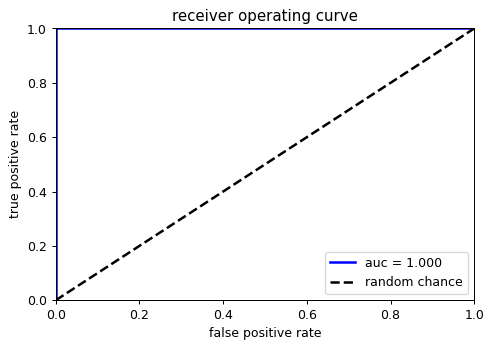

In [26]:
plt.rcParams['figure.dpi'] = 90
fpr, tpr, thresholds = roc_curve(Ytest[:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.savefig('ROC.png')
# np.savez('ROC', fpr=fpr, tpr=tpr, auc=roc_auc)
plt.show()